In this notebook, we compare GMM-MI with the [KSG estimator](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) and the [MINE estimator](https://github.com/gtegner/mine-pytorch) on a simple bivariate Gaussian with varying level of correlation. To run this notebook you would need to install the MINE package following the instructions in the repository; here we already cloned the repository for you and adapted the code to work with python 3.9, so that you only need to run:
```
cd mine-pytorch
pip install -e .
```
Note the MINE results are not "reproducible", in the sense that the seed is not fixed.

### Import packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
# GMM-MI
from gmm_mi.mi import EstimateMI
from gmm_mi.param_holders import GMMFitParamHolder, SelectComponentsParamHolder, MIDistParamHolder
from gmm_mi.gmm import GMMWithMI as GMM
from gmm_mi.utils.analytic_MI import calculate_MI_D1_analytical
# KSG
from sklearn.feature_selection import mutual_info_regression
# MINE
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from mine.models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0

Device: cpu


### Calculate the true MI of the synthetic models

In [2]:
rhos = np.linspace(-0.99, 0.99, 20)
N = 2e2
n_components = 1
weights = np.array([1.])
means = np.zeros((1, 2))
# fix random state for stability across runs
random_state = 13

analytic = []
for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])[0]
    analytic.append(calculate_MI_D1_analytical(covariances))

### KSG

In [3]:
knn_estimates = []
n_neighbors = 1 # keep minimum bias

initial_time = time.time()

for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = GMM(n_components=n_components, weights_init=weights, 
                   means_init=means, covariances_init=covariances, random_state=random_state)
    X = gmm_true.sample(N)[0]
    knn_estimates.append(mutual_info_regression(X[:, 0].reshape(-1, 1), X[:, 1], 
                                                n_neighbors=n_neighbors))

ksg_time = time.time()-initial_time    
    
print(f'Total time for KSG: {ksg_time:.3f} s')

Total time for KSG: 0.047 s


### MINE

In [4]:
mine_estimates = []

dim = 1
lr = 1e-3
epochs = 50
batch_size = 32
loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

initial_time = time.time()

for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = GMM(n_components=n_components, weights_init=weights, 
                   means_init=means, covariances_init=covariances, random_state=random_state)
    X = gmm_true.sample(N)[0]

    N = X.shape[0]
    train_size = int(0.9 * N)
    test_size = N - train_size

    train_set, test_set = train_test_split(X, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)
    
    trainer = Trainer(max_epochs=epochs)
    trainer.fit(model)
    trainer.test()

    mine_estimates.append(model.avg_test_mi)

mine_time = time.time()-initial_time    
    
print(f'Total time for MINE: {mine_time:.3f} s')

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightnin

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1386: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v20.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v20.ckpt
/home/dpiras/.conda/envs/MI/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:489: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off fo

Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v21.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v21.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v22.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v22.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v23.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v23.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v24.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v24.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v25.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v25.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v26.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v26.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v27.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v27.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v28.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v28.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v29.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v29.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v30.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v30.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v31.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v31.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v32.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v32.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v33.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v33.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v34.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v34.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v35.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v35.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v36.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v36.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v37.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v37.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v38.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v38.ckpt


Testing: 0it [00:00, ?it/s]

Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | T           | CustomSequential | 10.5 K
1 | energy_loss | Mine             | 10.5 K
-------------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v39.ckpt
Loaded model weights from checkpoint at /home/dpiras/MI/notebooks/comparisons/lightning_logs/version_498207/checkpoints/epoch=49-step=300-v39.ckpt


Testing: 0it [00:00, ?it/s]

Total time for MINE: 54.052 s


### GMM-MI

In [5]:
# all unspecified parameters are set to their default values

# parameters for every GMM fit that is being run
gmm_fit_params = GMMFitParamHolder(threshold_fit=1e-5,
                                   reg_covar=1e-12)

# parameters to choose the number of components
select_components_params = SelectComponentsParamHolder(n_inits=3,
                                                       n_folds=2)

# parameters for MI distribution estimation
mi_dist_params = MIDistParamHolder(n_bootstrap=100,
                                   MC_samples=1e4)

In [6]:
all_MI_estimates = np.zeros((len(rhos), 2))

initial_time = time.time()

for r, rho in enumerate(rhos):
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = GMM(n_components=n_components, weights_init=weights, 
                   means_init=means, covariances_init=covariances, random_state=random_state)
    X = gmm_true.sample(N)[0]

    mi_estimator = EstimateMI(gmm_fit_params=gmm_fit_params,
                              select_components_params=select_components_params)
    MI_mean, MI_std = mi_estimator.fit_estimate(X, mi_dist_params=mi_dist_params)   

    # store results
    all_MI_estimates[r, 0] = MI_mean
    all_MI_estimates[r, 1] = MI_std

gmm_mi_time = time.time()-initial_time
print(f'Total time for GMM: {gmm_mi_time:.3f} s')

100%|██████████| 100/100 [00:00<00:00, 301.32it/s]

Total time for GMM: 13.499 s


### Plot results

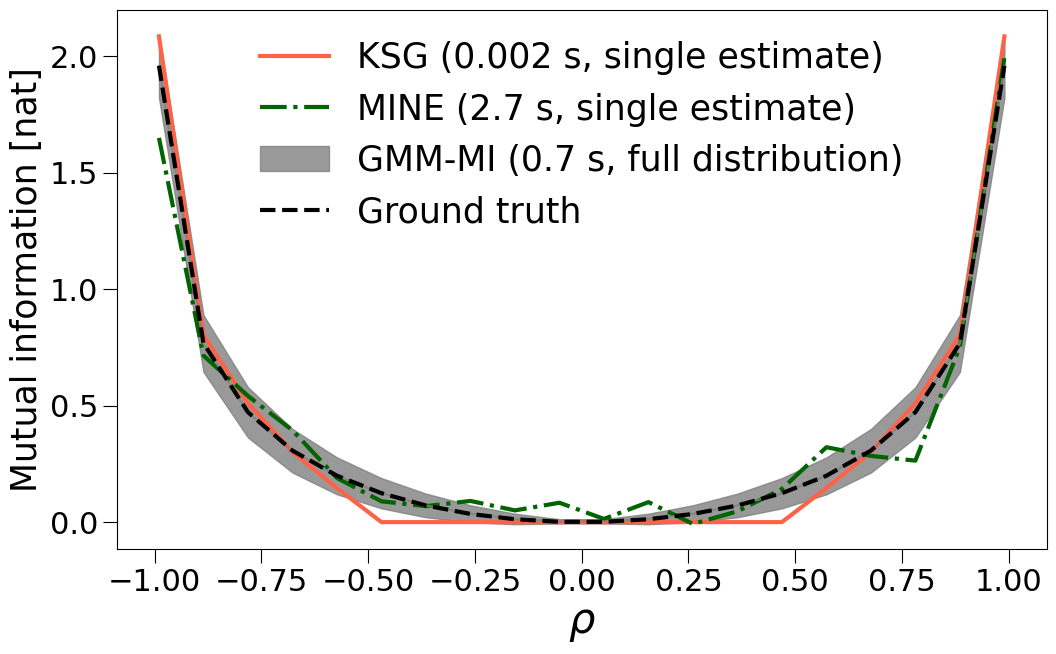

In [7]:
# let's plot the results
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

sigmas = 2
lw = 3

ax.tick_params(axis='both', which='major', labelsize=22, size=10)
ax.plot(rhos, knn_estimates, c='tomato', lw=lw, label=f'KSG ({ksg_time/len(rhos):.3f} s, single estimate)')
ax.plot(rhos, mine_estimates, c='darkgreen', ls='-.', lw=lw, label=f'MINE ({mine_time/len(rhos):.1f} s, single estimate)')
ax.plot(rhos, all_MI_estimates[:, 0], color='grey', alpha=0.8)
ax.fill_between(rhos, all_MI_estimates[:, 0] - sigmas*all_MI_estimates[:, 1], 
                all_MI_estimates[:, 0]+sigmas*all_MI_estimates[:, 1], color='grey', 
                alpha=0.8, label=f'GMM-MI ({gmm_mi_time/len(rhos):.1f} s, full distribution)')
ax.plot(rhos, analytic, ls='--', c='black', lw=lw, label='Ground truth')

ax.legend(fontsize=25, frameon=False)
        
ax.set_xlabel(r'$\rho$', fontsize=30)
ax.set_ylabel('Mutual information [nat]', fontsize=25);

plt.savefig('./figures/D1_comparison.pdf',  bbox_inches='tight');